In [35]:
import urllib.request 
from bs4 import BeautifulSoup as bs
from pywebcopy import save_webpage
import pandas as pd
import re
import numpy as np
import os
import glob
from langdetect import detect
import spacy
npl = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
from pattern.en import lemma
from string import punctuation
import pickle

In [257]:
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20

In [117]:
def preprocess_text(Plot):
    Plot = re.sub('[^a-zA-Z0-9 \n\.]', ' ', Plot)
    Plot = Plot.replace('.',' ')
    doc = npl(Plot.lower())
    doc = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not str(token).isnumeric() and len(token) > 1]
    return doc

def first_engine():
    print('please put query here')
    string = input().strip().lower()
    print("how many rows to display?")
    n_rows = int(input().strip())
    query = preprocess_text(string)
    try:
        print('found {} books'.format(df.loc[df.index.intersection(set.intersection(*[set(index[i]) for i in query]))].shape[0]))
        return df.loc[df.index.intersection(set.intersection(*[set(index[i]) for i in query])),['bookTitle','Plot','Url']].head(n_rows)
    except:
        print('no book found')
        
def second_engine():
    print('please put query here')
    string = input().strip().lower()
    print("how many rows to display?")
    n_rows = int(input().strip())
    query = preprocess_text(string)
    try:
        df_ = df.loc[df.index.intersection(set.intersection(*[set(index[i]) for i in query])),['bookTitle','Plot','Url']].reset_index()
        print('found {} books'.format(df_.shape[0]))
        cosine = []
        for i in df_["index"].str.slice(start=9).astype(int) - 1:
            cosine.append((tfidfWeigths[i]*tfidf.transform(countVec.transform([string])).T).A[0][0])
        df_['cosine'] = cosine
        display(df_[['bookTitle','Plot','Url','cosine']].sort_values(by = "cosine",ascending = False).head(n_rows))
    except:
        print('no book found')
        
        
def third_engine():
    print('please put query here')
    string = input().strip().lower()
    print("how many rows to display?")
    n_rows = int(input().strip())
    query = preprocess_text(string)
    try:
        df_ = df.loc[df.index.intersection(set.intersection(*[set(index[i]) for i in query])),['bookTitle','Plot','Url']].reset_index()
        print('found {} books'.format(df_.shape[0]))
        cosine = []
        cosine_title = []
        for i in df_["index"].str.slice(start=9).astype(int) - 1:
            cosine.append((tfidfWeigths[i]*tfidf.transform(countVec.transform([string])).T).A[0][0])
        for i in df_["index"]:
            cosine_title.append((tfidf.transform(countVec.transform([string]))*tfidf.transform(countVec.transform([df_.bookTitle[df_["index"] == i].item().lower()])).T).A[0][0])
        df_['cosine'] = cosine
        df_["cosine_title"] = cosine_title
        df_['new_index'] = df_['cosine']+df_["cosine_title"]
        display(df_[['bookTitle','Plot','Url','new_index']].sort_values(by = "new_index",ascending = False).head(n_rows))
    except:
        print('no book found')

## **[Phase 1]** get the book links

In [ ]:
for i in range(299,301):
    print(i)
    link = "https://www.goodreads.com/list/show/1.Best_Books_Ever?page={}".format(i)
    page = urllib.request.urlretrieve (link, "html/page {}.html".format(i))
    soup = bs(open("html/page {}.html".format(i),encoding = "UTF-8"),features = 'lxml')
    links = soup.find_all('a',{"class": "bookTitle"})
    names = soup.find_all('span',{'itemprop':'name','role':'heading'},text = True)
    titles = []
    href = []
    all = []
    for link in links:
        href.append("https://www.goodreads.com/{}".format(link.get('href')))
    for name in names:
        titles.append(re.sub('[^a-zA-Z0-9 \n\.]', '', name.text)) #remove all special characters from title
    for j in range(0,len(names)):
        all.append("{}: {}".format(titles[j],href[j]))
    with open("links/links page{}.txt".format(i), "w") as outfile:
        outfile.write("\n".join(all),)

## **[Phase 2]** get books information

In [ ]:
#rifai dalla 0 alla 10
for number in range(1,301):
    if not os.path.exists('{}\\html\\page{}'.format(os.getcwd(),number)):
        os.mkdir('{}\\html\\page{}'.format(os.getcwd(),number))
    with open('{}\\links\\links page{}.txt'.format(os.getcwd(),number)) as f:
        for n,line in enumerate(f):
            if  number <= 61 and number >= 52:   # if program bloks (number == 240 and n >= 52) or
                try:
                    book_name = re.sub('[^a-zA-Z0-9 \n\.]', '_',line.rsplit(':',1)[0])
                    link = line.split(':',1)[1]
                    page = urllib.request.urlretrieve(link, "html/page{}/{}.html".format(number,book_name))
                    soup = bs(open(page[0],encoding = "UTF-8"),features = 'lxml')
                    language = detect(soup.find('div',{'id':'descriptionContainer'}).span.text.strip())
                except:
                    book_name = re.sub('[^a-zA-Z0-9 \n\.]', '_',line.rsplit(':',1)[0])
                    link = '{}from_search=true'.format(line.split(':',1)[1]).replace('\n','?')
                    try:
                        page = urllib.request.urlretrieve(link, "html/page{}/{}.html".format(number,book_name))
                        soup = bs(open(page[0],encoding = "UTF-8"),features = 'lxml')
                    except:
                        continue
                    try:
                        language = detect(soup.find('div',{'id':'descriptionContainer'}).span.text.strip())
                    except:
                        continue
                print('page:',number,'book:',n,':',line,'written in',language)
                if language == 'en' and book_name.strip() != '':
                    bookTitle = soup.find('h1',text = True).text.strip()
                    try:
                        bookSeries = soup.find('h2',{'id':'bookSeries'}).a.text.strip()
                    except:
                        bookSeries = ''
                    try:
                        bookAuthors = soup.find('div',{'id':'bookAuthors'}).a.span.text.strip()
                    except:
                        bookAuthors = ''
                    try:
                        ratingValue = soup.find('span',{'itemprop':'ratingValue'}).text.strip()
                    except:
                        ratingValue = ''
                    try:
                        ratingCount = soup.find('meta',{'itemprop':'ratingCount'}).get('content').strip()
                    except:
                        ratingCount = ''
                    try:
                        reviewCount = soup.find('meta',{'itemprop':'reviewCount'}).get('content').strip()
                    except:
                        reviewCount = ''
                    try:
                        Plot = soup.find('div',{'id':'descriptionContainer'}).select("[style*='display:none']")[0].text.strip()
                    except:
                        Plot = ''
                    try:
                        NumberofPages = soup.find('span',{'itemprop':'numberOfPages'}).text.strip().split()[0]
                    except:
                        NumberofPages = ''
                    try:
                        Published = soup.find('div',{'id':'details'}).contents[3].text.split('\n')[2].strip()
                    except:
                        Published = ''
                    Characters = ''
                    Setting = ''
                    try:
                        a = soup.find_all('div',{'class':['infoBoxRowTitle','infoBoxRowItem']})
                        for i in a:
                            if i.text == 'Characters':
                                Characters = i.next.next.next.text.replace('...less\n','').replace('...more','')
                            if i.text == 'Setting':
                                Setting = ' '.join(i.next.next.next.text.strip().split())
                    except:
                        pass
                    Url = link
                    info = pd.DataFrame({"bookTitle":[bookTitle],"bookSeries":[bookSeries],"bookAuthors":[bookAuthors],"ratingValue":[ratingValue],"ratingCount":[ratingCount],"Plot":[Plot],"NumberofPages":[NumberofPages],"Published":[Published],"Characters":[Characters],"Setting":[Setting],"Url":[Url]})
                    if not os.path.exists('{}\\article\\page{}'.format(os.getcwd(),number)):
                        os.mkdir('{}\\article\\page{}'.format(os.getcwd(),number))
                    if len(bookTitle) > 100:
                        bookTitle = bookTitle[0:100]
                    info.to_csv('{}\\article\\page{}\\'.format(os.getcwd(),number) + 'article_{}.tsv'.format(re.sub('[^a-zA-Z0-9 \n\.]', '_',bookTitle)),sep = "\t",index = False)

## **[Phase 3]** data pre-processing

In [ ]:
li = []
for i in range(1,301):
    files = glob.glob(os.getcwd() + '\\article\\page{}\\*.tsv'.format(i))
    for file in files:
        try:
            li.append(pd.read_csv(file,sep = '\t',index_col=None, header=0))
df = pd.concat(li)

In [ ]:
df.to_csv('dataset\\df_1.csv',sep = "\t")

In [6]:
df = pd.read_csv('dataset\\df_1.csv',sep = "\t")
df['Plot'] = df.Plot.fillna(' ')
df['Token_plot'] = df['Plot'].apply(preprocess_text)
df.to_csv('dataset\\df.csv',sep = "\t",index=False)

In [93]:
df = pd.read_csv('dataset\\df.csv',sep = "\t")
df = df.drop([i for i in df.columns if 'Unnamed:' in i],axis = 1) 

In [94]:
df.index = ['document {}'.format(i) for i in range(1,df.shape[0]+1)]

## **[Phase 4]** first inverted index

In [101]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
countVec = CountVectorizer(stop_words='english', min_df=.01, max_df=.90)
countVec.fit(df["Token_plot"].fillna(' '))
countVec_count = countVec.transform(df["Token_plot"].fillna(' '))

#make a new data frame with columns term and occurrences, meaning word and number of occurences
bowListFrame = pd.DataFrame(countVec_count.toarray(),index = ['document {}'.format(i) for i in range(1,df.shape[0]+1)],columns = list(countVec.get_feature_names()))
display(bowListFrame)
#save dictionary
import pickle
Dict = {i:bowListFrame[i][bowListFrame[i] > 0].keys().values for i in bowListFrame.columns}
with open('dataset\\index.p', 'wb') as fp:
    pickle.dump(Dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

,abandon,ability,able,abuse,accept,accident,acclaim,account,achieve,act,...,world,worth,write,writer,writing,wrong,year,york,young,youth
document 1,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
document 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
document 3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
document 4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
document 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
document 26391,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
document 26392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
document 26393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
document 26394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1


In [95]:
# load dictionary
with open('dataset\\index.p', 'rb') as fp:
    index = pickle.load(fp)

In [131]:
#have fun with the first engine!!
first_engine()

please put query here
queen princess
how many rows to display?
5
found 84 books


,bookTitle,Plot,Url
document 238,Last Sacrifice,"They come first.My vision was growing dimmer, ...",https://www.goodreads.com//book/show/6527740-...
document 564,The Goose Girl,Mythopoeic Fantasy Award nominee for Children'...,https://www.goodreads.com//book/show/179064.T...
document 979,Winter,"Princess Winter is admired for her grace, kind...",https://www.goodreads.com//book/show/13206900...
document 1344,The Demon King,Times are hard in the mountain city of Fellsma...,https://www.goodreads.com//book/show/6342491-...
document 1578,Bitterblue,Eight years have passed since the young Prince...,https://www.goodreads.com//book/show/12680907...


## **[Phase 5]** second inverted index

In [102]:
tfidf = TfidfTransformer()
tfidfWeigths = tfidf.fit_transform(countVec_count)
tfidfDf=pd.DataFrame(tfidfWeigths.toarray(),index = ['document {}'.format(i) for i in range(1,df.shape[0]+1)],columns = list(countVec.get_feature_names()))

In [269]:
a={i:dict(tfidfDf[i][tfidfDf[i] > 0]) for i in tfidfDf.columns}
with open('dataset\\index_2.p', 'wb') as fp:
    pickle.dump(a, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [99]:
with open('dataset\\index_2.p', 'rb') as fp:
    index_2 = pickle.load(fp)

In [132]:
#here it is the second engine!!
second_engine()

please put query here
queen princess
how many rows to display?
5
found 84 books


,bookTitle,Plot,Url,cosine
53,The Black Rose,"Princess Wilhelmina Diamante, by birthright, s...",https://www.goodreads.com//book/show/18044418...,0.577737
22,The Princess Saves Herself in This One,"""Ah, life- the thing that happens to us while ...",https://www.goodreads.com//book/show/30075802...,0.531910
2,Winter,"Princess Winter is admired for her grace, kind...",https://www.goodreads.com//book/show/13206900...,0.523864
75,"Guenevere, Queen of the Summer Country",Last in a line of proud queens elected to rule...,https://www.goodreads.com//book/show/56351.Gu...,0.516054
68,Angela: Queen of Hel: Journey to the Funderworld,Hel hath a new fury! She was stolen from Asgar...,https://www.goodreads.com//book/show/28020938...,0.508380


## **[Phase 6]** define a new score!

In [133]:
#this new engine takes into account also the similarity between the query and the title!
third_engine()

please put query here
queen princess
how many rows to display?
5
found 84 books


,bookTitle,Plot,Url,new_index
22,The Princess Saves Herself in This One,"""Ah, life- the thing that happens to us while ...",https://www.goodreads.com//book/show/30075802...,1.274350
29,Princess Ben,"""My gown suited me as well as I could ever hop...",https://www.goodreads.com//book/show/2153427....,1.201592
33,Ash Princess,Theodosia was six when her country was invaded...,https://www.goodreads.com//book/show/32505753...,1.131240
26,The Heretic Queen,"In ancient Egypt, a forgotten princess must ov...",https://www.goodreads.com//book/show/2897258-...,1.113086
11,The Queen of the Tearling,"Magic, adventure, mystery, and romance combine...",https://www.goodreads.com//book/show/22864842...,1.051088


## Algorithmic question
### You are given a string written in english capital letters, for example S="CADFECEILGJHABNOPSTIRYOEABILCNR." You are asked to find the maximum length of a subsequence of characters that is in alfabetical order. For example, here a subsequence of characters in alphabetical order is the "ACEGJSTY": "CADFECEILGJHABNOFPSTIRYOEABILCNR." Among all the possible such sequences, you are asked to find the one that is the longest.

In [45]:
#s = "CADFECEILGJHABNOFPSTIRYOEABILCNR"
from time import time
def generate(st, s): 
    if len(s) == 0: 
        return
  
    # If current string is not already present. 
    if s not in st:
        if s == ''.join(sorted(s)):
            st.add(s) 
  
        # Traverse current string, one by one 
        # remove every character and recur. 
        for i in range(len(s)): 
            t = list(s).copy() 
            t.remove(s[i]) 
            t = ''.join(t) 
            generate(st, t) 
  
    return
s = ["DADO","ALBAS","TAVOLO","JVNLKVM","VERCINGE","DATASCIENCE","LASAPIENZA"]
lun = []
times = []
for i in s:
    lun.append(len(i))
    start = time()
    st = set() 
    generate(st, i)
    print(i)
    print(st)
    print('the longest alphabetic subsequence is:',max(list(st),key = len))
    times.append(time() - start)

DADO
{'A', 'AO', 'DDO', 'D', 'O', 'DO', 'ADO', 'DD', 'AD'}
the longest alphabetic subsequence is: DDO
ALBAS
{'A', 'S', 'L', 'B', 'LS', 'AAS', 'AA', 'AS', 'BS'}
the longest alphabetic subsequence is: AAS
TAVOLO
{'A', 'AO', 'TV', 'AL', 'T', 'ALO', 'AOO', 'L', 'AV', 'O', 'OO', 'V', 'LO'}
the longest alphabetic subsequence is: ALO
JVNLKVM
{'JLM', 'L', 'NV', 'V', 'M', 'JV', 'JK', 'JL', 'J', 'K', 'JM', 'VV', 'KV', 'KM', 'JN', 'JVV', 'N', 'JKM', 'JKV', 'JNV', 'LV', 'LM', 'JLV'}
the longest alphabetic subsequence is: JLM
VERCINGE
{'N', 'EE', 'CG', 'CN', 'E', 'G', 'I', 'CIN', 'V', 'R', 'C', 'IN', 'CE', 'CI'}
the longest alphabetic subsequence is: CIN
DATASCIENCE
{'CC', 'A', 'AAI', 'DEE', 'S', 'D', 'AAC', 'AA', 'C', 'AACE', 'ACCE', 'EE', 'AI', 'AACC', 'E', 'AS', 'AACCE', 'DI', 'CE', 'DN', 'DE', 'DIN', 'AAEE', 'AAN', 'T', 'DS', 'AE', 'CCE', 'AC', 'IN', 'DT', 'N', 'ACC', 'AEE', 'AAIN', 'AAE', 'AAS', 'I', 'AN', 'AIN', 'ACE'}
the longest alphabetic subsequence is: AACCE
LASAPIENZA
{'A', 'AAA', 'LZ',

## Show that the running time is exponential

In [69]:
import matplotlib.pyplot as plt
import scipy
lung = sorted(lun)
times = sorted(times)
def exponential(x, a, k, b):
    return a*np.exp(x*k) + b
popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, lung, times,p0=(1, 1e-6, 1))

In [87]:
xx = np.linspace(0,11,100)
yy = exponential(xx, *popt_exponential)

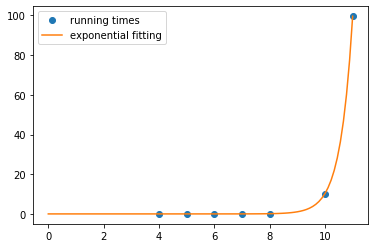

In [92]:
plt.plot(lung,times,'o',label='running times')
plt.plot(xx,yy,label='exponential fitting')
plt.legend()